### 1. Import Libraries

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 7.8 MB/s eta 0:00:00


In [2]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3


In [3]:
import pandas as pd
import os
import re
import numpy as np
from keras.layers import Input
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Embedding, Bidirectional, GRU
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam

In [4]:
if 'COLAB_TPU_ADDR' in os.environ:
    TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
    print('Connected to TPU')
    print("All devices: ", tf.config.list_logical_devices('TPU'))
else:
    strategy = tf.distribute.OneDeviceStrategy('GPU:0')  # Fallback to GPU if no TPU


Connected to TPU
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


### 2. Data Loading

In [5]:
import pandas as pd
from datasets import Dataset, DatasetDict

TRAIN_PATH = 'train(1).csv'
VAL_PATH = 'val(1).csv'
TEST_PATH = 'test(1).csv'

# Load CSV files using pandas
train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)
test_df = test_df.rename(columns={'cmt': 'comment'})
test_df = test_df.rename(columns={'id': 'cmtId'})
# Convert DataFrames to Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict containing the splits
raw_datasets = DatasetDict({'train': train_dataset, 'val': val_dataset, 'test': test_dataset})


In [6]:
import pandas as pd
df_train = pd.read_csv(TRAIN_PATH)
df_val = pd.read_csv(VAL_PATH)
df_test = pd.read_csv(TEST_PATH)

df_test = df_test.rename(columns={'cmt': 'comment'})
df_test = df_test.rename(columns={'id': 'cmtId'})

In [ ]:
df_train.columns

Index(['cmtId', 'itemId', 'comment', 'price', 'service', 'ship', 'performance',
       'genuine', 'configuration', 'access', 'other', 'model'],
      dtype='object')

### 3. Data Prepare

#### Standardlize Ouput

In [7]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(2, len(df.columns)):
            sentiment = df.iloc[row, col]
            if sentiment == 0.0:
                row_one_hot.append([1, 0, 0])  # None
            elif sentiment == 1.0:
                row_one_hot.append([0, 1, 0])  # Pos
            elif sentiment == 2.0:
                row_one_hot.append([0, 0, 1])  # Neg
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

y_train = make_outputs(df_train)
y_val = make_outputs(df_val)
y_test = make_outputs(df_test)

#### Tokenizing

In [8]:
from transformers import AutoTokenizer, TFAutoModel

PRETRAINED_MODEL = 'vinai/phobert-base'
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

def tokenize_function(dataset):
    cmt_texts = dataset['comment']
    return tokenizer(cmt_texts, max_length=tokenizer.model_max_length, padding='max_length', truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)


Map:   0%|          | 0/2920 [00:00<?, ? examples/s]

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

Map:   0%|          | 0/370 [00:00<?, ? examples/s]

#### Prepare for Models

In [9]:
MAX_SEQUENCE_LENGTH = tokenizer.model_max_length
MODEL_PATH = 'reviews_shopee_model'
BATCH_SIZE = 20

STEPS_PER_EPOCH = len(raw_datasets['train']) // (BATCH_SIZE)
VALIDATION_STEPS = len(raw_datasets['val']) // (BATCH_SIZE)
EPOCHS = 10

In [10]:
def to_tensorflow_format(tokenized_dataset):
    features = tokenized_dataset.features
    return tokenized_dataset.remove_columns(list(features)[:-3]).with_format('tensorflow')

from tensorflow.data import Dataset
def preprocess_tokenized_dataset(tokenized_dataset, tokenizer, labels, batch_size, shuffle=False,repeat=True):
    tf_dataset = to_tensorflow_format(tokenized_dataset)
    features = {x: tf_dataset[x] for x in tokenizer.model_input_names}
    labels = labels.reshape(len(labels), -1)

    tf_dataset = Dataset.from_tensor_slices((features, labels))

    if shuffle:
        tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset))
    tf_dataset = tf_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    if repeat:
        tf_dataset = tf_dataset.repeat(10)  # Repeat the dataset for multiple epochs

    return tf_dataset

train_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['train'], tokenizer, y_train, BATCH_SIZE, shuffle=True)
val_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['val'], tokenizer, y_val, BATCH_SIZE, repeat=False)
test_tf_dataset = preprocess_tokenized_dataset(tokenized_datasets['test'], tokenizer, y_test, BATCH_SIZE, repeat=False)
val_tf_dataset


<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 27), dtype=tf.uint8, name=None))>

In [11]:
bert_model = TFAutoModel.from_pretrained(PRETRAINED_MODEL)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [12]:
import numpy as np
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.layers import Input, Dense, Concatenate,Bidirectional, LSTM, Embedding, SpatialDropout1D, Concatenate, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_bert_rcnn_model():
    input_ids = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
    with strategy.scope():
        bert_model = TFAutoModel.from_pretrained(PRETRAINED_MODEL)

    # Tokenize the input text and get BERT embeddings
    bert_output = bert_model(input_ids)[0]

    # RCNN architecture
    x = SpatialDropout1D(0.2)(bert_output)
    l_embedding = Lambda(lambda x: tf.concat([tf.zeros_like(x[:, :1]), x[:, :-1]], axis=1))(x)
    r_embedding = Lambda(lambda x: tf.concat([tf.zeros_like(x[:, :1]), x[:, 1:]], axis=1))(x)
    forward = LSTM(256, return_sequences=True)(l_embedding)
    backward = LSTM(256, return_sequences=True, go_backwards=True)(r_embedding)
    backward = Lambda(lambda x: tf.reverse(x, axis=[1]))(backward)
    together = [forward, bert_output, backward]
    together = Concatenate(axis=-1)(together)

    # Semantic convolution
    semantic = Conv1D(256, kernel_size=1, activation="relu")(together)
    sentence_embed = GlobalMaxPooling1D()(semantic)

    # Output layer for multi-label classification
    preds = Dense(9*3, activation='sigmoid')(sentence_embed)

    # Create and compile the model
    model = Model(inputs=input_ids, outputs=preds)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')

    return model


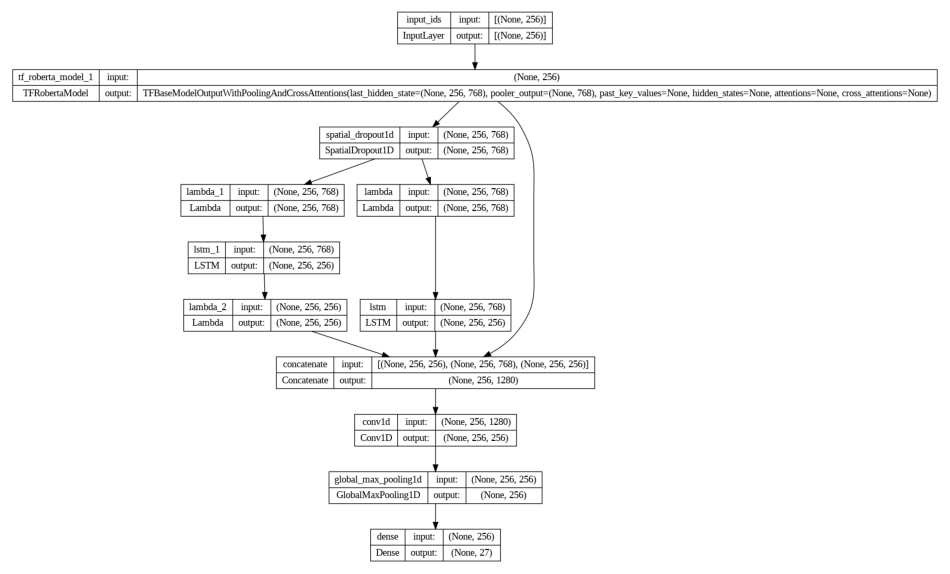

In [27]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(12, 8))
img = plt.imread('model_architecture.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [14]:
with strategy.scope():
    model = create_bert_rcnn_model()
    history = model.fit(
        train_tf_dataset,
        validation_data=val_tf_dataset,
        validation_steps=VALIDATION_STEPS,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        callbacks=[
            early_stop_callback,
            # checkpoint_callback
        ],
        verbose=1,
    )
    model.save_weights('weights.h5')


Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids', 'attention_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


146/146 [==============================] - 152s 290ms/step - loss: 0.3412 - val_loss: 0.3556
Epoch 2/10
146/146 [==============================] - 28s 192ms/step - loss: 0.2733 - val_loss: 0.3180
Epoch 3/10
146/146 [==============================] - 28s 192ms/step - loss: 0.2214 - val_loss: 0.2720
Epoch 4/10
146/146 [==============================] - 29s 200ms/step - loss: 0.1823 - val_loss: 0.2401
Epoch 5/10
146/146 [==============================] - 28s 192ms/step - loss: 0.1602 - val_loss: 0.2236
Epoch 6/10
146/146 [==============================] - 28s 193ms/step - loss: 0.1462 - val_loss: 0.2233
Epoch 7/10
146/146 [==============================] - 28s 191ms/step - loss: 0.1345 - val_loss: 0.2175
Epoch 8/10
146/146 [==============================] - 28s 192ms/step - loss: 0.1245 - val_loss: 0.2241
Epoch 9/10
146/146 [==============================] - 28s 191ms/step - loss: 0.1154 - val_loss: 0.2115
Epoch 10/10
146/146 [==============================] - 29s 198ms/step - loss: 0.108

#### Define Model

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# Stop if no improvement after 5 epochs
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


#### Training model

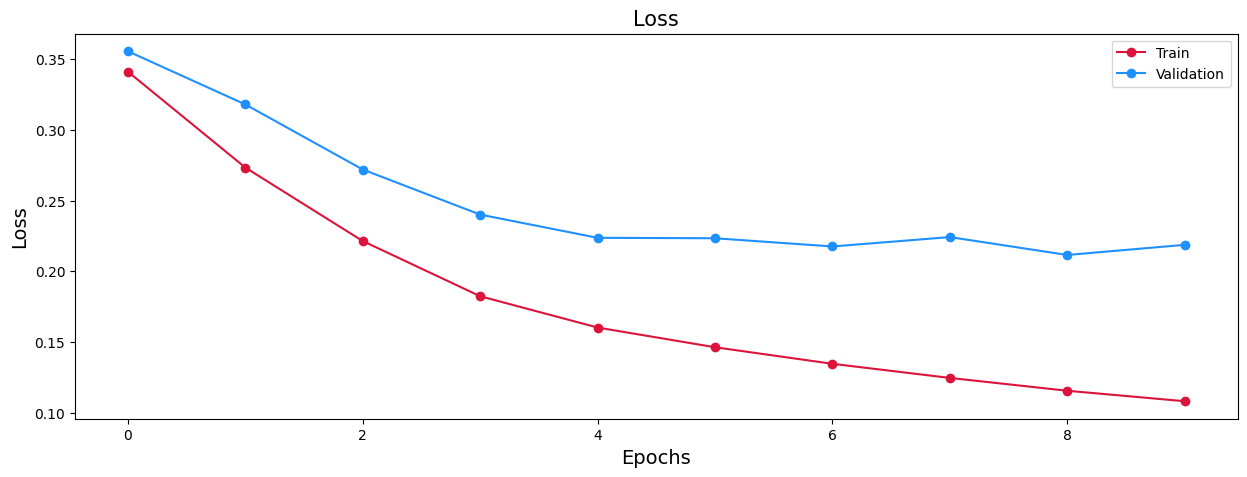

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss', fontsize=15)
plt.legend(loc='best')
fig.savefig('evaluation.png', bbox_inches='tight')
plt.show()


In [16]:
from tensorflow.train import latest_checkpoint
with strategy.scope():
    reloaded_model = create_bert_rcnn_model()
    # reloaded_model.load_weights(latest_checkpoint(checkpoint_dir))
    reloaded_model.load_weights('weights.h5')
    reloaded_model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  134998272  ['input_ids[0][0]']              
 odel)                          thPoolingAndCrossAt                                               
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                               
                                 768),                                                            
                                 pooler_output=(Non                                         

#### Load Model

### Predict on test data

In [17]:
y_test_argmax = np.argmax(y_test, axis=-1)
y_test_argmax

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1]])

In [18]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 3)
    return np.argmax(y_pred, axis=-1) # sentiment values (position that have max value)
def print_acsa_pred(replacements, categories, sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments):
        if sentiment: print(f'=> {category},{sentiment}')


with strategy.scope():
    y_pred = predict(reloaded_model, test_tf_dataset, BATCH_SIZE, verbose=1)
    reloaded_model.evaluate(test_tf_dataset,batch_size=BATCH_SIZE, verbose=1)


19/19 [==============================] - 23s 322ms/step - loss: 0.4554


In [19]:
replacements = {0: 'None', 1: 'positive', 2: 'negative'}
categories = df_test.columns[2:]
print('Example:', df_test['comment'][1])
print_acsa_pred(replacements, categories, y_pred[1])

Example: sp ok. youtube tiktok hợp_lý . game mua mini 2
=> price,None
=> service,None
=> ship,None
=> performance,positive
=> genuine,None
=> configuration,None
=> access,None
=> other,None
=> model,None


### 5. Evaluate

#### Detection Aspects

In [20]:
y_pred

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [21]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])

In [22]:

from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

               precision    recall  f1-score   support

                  0.8639    0.8659    0.8649      2499
       access     1.0000    0.0000    0.0000        25
configuration     1.0000    0.0000    0.0000       134
      genuine     1.0000    0.0000    0.0000        51
        model     0.8011    0.8735    0.8357       166
        other     1.0000    0.0000    0.0000        40
  performance     0.3408    0.9907    0.5072       107
        price     0.7571    0.8689    0.8092        61
      service     0.7267    0.8862    0.7985       123
         ship     0.6814    0.6210    0.6498       124

     accuracy                         0.7970      3330
    macro avg     0.8171    0.5106    0.4465      3330
 weighted avg     0.8403    0.7970    0.7755      3330



#### Polarity

In [23]:
y_test_flat = y_test_argmax.flatten()
y_pred_flat = y_pred.flatten()
target_names = list(map(str, replacements.values()))


In [24]:
polarity_report = classification_report(y_test_flat, y_pred_flat, digits=4, output_dict=True)
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names, digits=4))


              precision    recall  f1-score   support

        None     0.8639    0.8659    0.8649      2499
    positive     0.5933    0.6156    0.6042       718
    negative     0.3375    0.2389    0.2798       113

    accuracy                         0.7907      3330
   macro avg     0.5982    0.5735    0.5830      3330
weighted avg     0.7877    0.7907    0.7888      3330



#### Aspect + Polarity

In [25]:
aspect_polarity_test = []
aspect_polarity_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_polarity_test.append(f'{categories[index]},{replacements[col_test]}')
        aspect_polarity_pred.append(f'{categories[index]},{replacements[col_pred]}')



In [26]:
aspect_polarity_report = classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1))

                        precision    recall  f1-score   support

           access,None     0.9324    1.0000    0.9650       345
       access,negative     1.0000    0.0000    0.0000         7
       access,positive     1.0000    0.0000    0.0000        18
    configuration,None     0.6378    1.0000    0.7789       236
configuration,negative     1.0000    0.0000    0.0000        35
configuration,positive     1.0000    0.0000    0.0000        99
          genuine,None     0.8622    1.0000    0.9260       319
      genuine,negative     1.0000    0.0000    0.0000         4
      genuine,positive     1.0000    0.0000    0.0000        47
            model,None     0.8889    0.8235    0.8550       204
        model,negative     0.3333    0.1250    0.1818        16
        model,positive     0.7771    0.9067    0.8369       150
            other,None     0.8919    1.0000    0.9429       330
        other,positive     1.0000    0.0000    0.0000        40
      performance,None     0.9831    0.

### Predict for Actual Data

In [ ]:
test_data = pd.read_csv('tiki_cmt.csv')

In [ ]:
test_data.columns

Index(['Unnamed: 0', 'comment_id', 'product_id', 'content', 'customer_id',
       'seller_id', 'rating', 'date'],
      dtype='object')

In [ ]:
test_data = test_data[['comment_id','content']]

In [ ]:
test_data = test_data.rename(columns = {'content' : 'cmt', 'comment_id': 'id'})

In [ ]:
from datasets import Dataset
test_df_with_categories = test_data.copy()
category_columns = df_train.columns[2:]
for col in category_columns:
    test_df_with_categories[col] = 0

used_dataset = Dataset.from_pandas(test_df_with_categories)

# Create a DatasetDict containing the splits
datasets = DatasetDict({'train': train_dataset, 'val': val_dataset, 'test': used_dataset})

tokenized_data = datasets.map(tokenize_function, batched=True)
tokenized_data.set_format(type='tensorflow', columns=tokenizer.model_input_names)
y_test_new = make_outputs(test_df_with_categories)



Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Map:   0%|          | 0/370 [00:00<?, ? examples/s]

Map:   0%|          | 0/2999 [00:00<?, ? examples/s]

In [ ]:
from tensorflow.data import Dataset
test_dataset = preprocess_tokenized_dataset(tokenized_data['test'], tokenizer, y_test_new, BATCH_SIZE, repeat=False)

In [ ]:
test_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 27), dtype=tf.uint8, name=None))>

In [ ]:
from tensorflow.train import latest_checkpoint
with strategy.scope():
    reloaded_model = create_model(optimizer)
    # reloaded_model.load_weights(latest_checkpoint(checkpoint_dir))
    reloaded_model.load_weights('weights.h5')

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name=None), name='tf.__operators__.getitem_1/strided_slice:0', description="created by layer 'tf.__operators__.getitem_1'")


In [ ]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 3)
    return np.argmax(y_pred, axis=-1) # sentiment values (position that have max value)
def print_acsa_pred(replacements, categories, sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments):
        if sentiment: print(f'=> {category},{sentiment}')


with strategy.scope():
    y_pred = predict(reloaded_model, test_dataset, BATCH_SIZE, verbose=1)
    reloaded_model.evaluate(test_dataset,batch_size=BATCH_SIZE, verbose=1)


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x79a37ff253f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x79a37ff253f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
150/150 [==============================] - 16s 67ms/step


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x79a37da6ad40>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x79a37da6ad40>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
150/150 [==============================] - 16s 31ms/step - loss: 0.5940


In [ ]:
replacements = {0: 'None', 1: 'positive', 2: 'negative'}
categories = test_df_with_categories.columns[2:]
print('Example:', test_df_with_categories['cmt'][2])
print_acsa_pred(replacements, categories, y_pred[2])

Example: hàng đẹp , phụ_kiện đầy_đủ , máy cầm đầm tay_chơi game mượt_thơm mùi polime . cảm_ơn shop nhé
=> price,None
=> service,None
=> ship,None
=> performance,None
=> genuine,None
=> configuration,None
=> access,positive
=> other,None
=> model,positive


In [ ]:
result = test_df_with_categories.copy()
for i, col in enumerate(categories):
    result[col] = [replacements[pred] for pred in y_pred[:, i]]

for col in categories:
    result[col] = result[col].map({'None': 0, 'positive': 1, 'negative': 2})

result

,id,cmt,price,service,ship,performance,genuine,configuration,access,other,model
0,19360301,giao hàng nhanh . hàng chính hãng đẹp giới_thi...,0,0,1,0,1,0,0,0,1
1,18884049,nhanh_chóng kỹ máy hịn cám_ơn shop tiki,0,0,1,0,0,0,0,0,0
2,18593332,"hàng đẹp , phụ_kiện đầy_đủ , máy cầm đầm tay_c...",0,0,0,0,0,0,1,0,1
3,18540856,"quá tốt giá tiền . mua cha sử_dụng lướt_mượt ,...",1,0,0,1,0,1,0,0,0
4,18474709,dùng khá ổn tầm tiền bỏ . giáo hàng bọc cẩn_th...,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2994,18674812,"sạc pin vô nhanh , sạc nóng , thiết_kế nhỏ gọn...",0,0,1,0,0,0,2,0,0
2995,18432298,sạc nhanh đóng_gói cẩn_thận . khá uy_tín . ủng...,0,1,1,0,0,0,0,0,0
2996,19344473,"đóng_gói cẩn_thận , giao hàng nhanh_chóng . gi...",1,0,1,0,0,0,0,0,0
2997,19030059,"sạc nhanh , nóng_máy , kiểu_dáng đẹp",0,0,0,0,0,1,0,0,1


In [ ]:
result.to_csv('tiki_reviews_label.csv')